### Neural Network
使用torch.nn包来构建神经网络

nn包依赖autograd包来定义模型并求导。一个nn.model包含各个层和一个forward(input)方法，该方法返回output。

神经网络典型的训练过程：

 - 定义包含一些可学习的参数(或者叫权重)神经网络模型；
 - 在数据集上迭代；
 - 通过神经网络处理输入；
 - 计算损失(输出结果和正确值的差值大小)；
 - 将梯度反向传播回网络的参数；
 - 更新网络的参数，主要使用如下简单的更新原则： weight = weight learning_rate * gradient
 
 ### 定义网络

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flot_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flot_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [37]:
?nn.Module

In [51]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [63]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.1119, -0.0127,  0.0763, -0.1156, -0.0847,  0.1136,  0.0429,  0.1101,
         -0.0160,  0.0262]], grad_fn=<AddmmBackward>)


将所有参数的梯度缓存清零，然后进行反向传播

In [47]:
net.zero_grad()
out.backward(torch.randn(1, 10))

**回顾:**
  -  ``torch.Tensor``：一个用过自动调用 ``backward()``实现支持自动梯度计算的 *多维数组* ，
      并且保存关于这个向量的*梯度* w.r.t.
  -  ``nn.Module``：神经网络模块。封装参数、移动到GPU上运行、导出、加载等。
  -  ``nn.Parameter``：一种变量，当把它赋值给一个``Module``时，被 *自动* 地注册为一个参数。
  -  ``autograd.Function``：实现一个自动求导操作的前向和反向定义，每个变量操作至少创建一个函数节点，每一个``Tensor``的操作都回创建一个接到创建``Tensor``和 *编码其历史* 的函数的``Function``节点。
  
### 损失函数

In [64]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1)
# 均方误差损失函数
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3495, grad_fn=<MseLossBackward>)


In [31]:
loss.grad_fn

In [54]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [65]:
net.zero_grad()  # 清除梯度

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0049,  0.0019, -0.0113, -0.0009,  0.0133, -0.0197])


### 更新权重
------------------
在实践中最简单的权重更新规则是随机梯度下降（SGD）：

     ``weight = weight - learning_rate * gradient``

我们可以使用简单的Python代码实现这个规则：

```python

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```
但是当使用神经网络是想要使用各种不同的更新规则时，比如SGD、Nesterov-SGD、Adam、RMSPROP等，PyTorch中构建了一个包``torch.optim``实现了所有的这些规则。
使用它们非常简单：

In [66]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

训练一个分类器
=====================

上一讲中已经看到如何去定义一个神经网络，计算损失值和更新网络的权重。
你现在可能在想下一步。


关于数据？
----------------

一般情况下处理图像、文本、音频和视频数据时，可以使用标准的Python包来加载数据到一个numpy数组中。
然后把这个数组转换成 ``torch.*Tensor``。

-  图像可以使用 Pillow, OpenCV
-  音频可以使用 scipy, librosa
-  文本可以使用原始Python和Cython来加载，或者使用 NLTK或
   SpaCy 处理

特别的，对于图像任务，我们创建了一个包
``torchvision``，它包含了处理一些基本图像数据集的方法。这些数据集包括
Imagenet, CIFAR10, MNIST 等。除了数据加载以外，``torchvision`` 还包含了图像转换器，
``torchvision.datasets`` 和 ``torch.utils.data.DataLoader``。

``torchvision``包不仅提供了巨大的便利，也避免了代码的重复。

在这个教程中，我们使用CIFAR10数据集，它有如下10个类别
：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10的图像都是
3x32x32大小的，即，3颜色通道，32x32像素。

![](https://pytorch.org/tutorials/_images/cifar10.png)


训练一个图像分类器
----------------------------

依次按照下列顺序进行：

1. 使用``torchvision``加载和归一化CIFAR10训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 在测试集上测试网络


1. 读取和归一化 CIFAR10
------------------------------

使用``torchvision``可以非常容易地加载CIFAR10。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

**提示**

运行下面代码之前，先去https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 把数据下载下来，放在root路径中，直接运行速度十分缓慢。

In [2]:
transform = transforms.Compose(
        [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
?trainset

In [3]:
# pip install matplotlib

plane   cat truck  ship


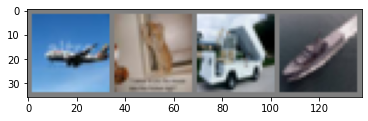

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
# 训练数据的分布
ll = [0 for i in range(10)]
for i, data in enumerate(trainloader):
    _, labels = data
    for k in range(4):
        ll[labels[k]] += 1

print(i)

12499
tensor([1, 5, 8, 5])
tensor([8.0006e-05, 4.0003e-04, 6.4005e-04, 4.0003e-04])


In [28]:
print(ll)

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


### 定义卷积神经网络

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 定义损失函数和优化器
交叉熵

带动量的随机梯度下降

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练网络
在数据迭代器上循环，将数据输入给网络并优化

In [40]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 梯度置0
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')  

[1,  2000] loss: 1.185
[1,  4000] loss: 1.217
[1,  6000] loss: 1.186
[1,  8000] loss: 1.186
[1, 10000] loss: 1.193
[1, 12000] loss: 1.184
[2,  2000] loss: 1.099
[2,  4000] loss: 1.112
[2,  6000] loss: 1.122
[2,  8000] loss: 1.105
[2, 10000] loss: 1.090
[2, 12000] loss: 1.093
[3,  2000] loss: 1.026
[3,  4000] loss: 1.049
[3,  6000] loss: 1.040
[3,  8000] loss: 1.023
[3, 10000] loss: 1.032
[3, 12000] loss: 1.038
[4,  2000] loss: 0.941
[4,  4000] loss: 0.968
[4,  6000] loss: 1.002
[4,  8000] loss: 0.980
[4, 10000] loss: 1.010
[4, 12000] loss: 0.988
[5,  2000] loss: 0.904
[5,  4000] loss: 0.918
[5,  6000] loss: 0.939
[5,  8000] loss: 0.917
[5, 10000] loss: 0.940
[5, 12000] loss: 0.946
Finished Training


### 在测试集上测试网络

GroundTruth:    cat  ship  ship plane


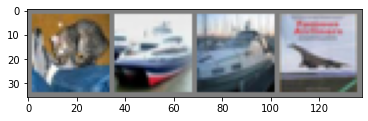

In [41]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [42]:
outputs = net(images)

In [43]:
outputs

tensor([[-2.6889, -1.7149, -0.4185,  3.7925,  0.7680,  2.3114,  2.2923, -1.3664,
          0.2355, -2.3499],
        [ 3.8859,  3.7928, -1.2293, -1.4280, -3.0720, -2.6911, -4.2466, -2.2725,
          5.1498,  2.1291],
        [ 1.8658,  0.5953, -0.3577, -0.4351, -0.2954, -0.9823, -1.7858, -1.1532,
          1.8992,  0.6787],
        [ 5.2940,  0.3237, -0.1361, -2.2752, -1.9100, -2.1857, -2.5514, -1.7175,
          5.1497,  0.8776]], grad_fn=<AddmmBackward>)

In [44]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [46]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 70 %
Accuracy of  bird : 44 %
Accuracy of   cat : 29 %
Accuracy of  deer : 62 %
Accuracy of   dog : 49 %
Accuracy of  frog : 73 %
Accuracy of horse : 67 %
Accuracy of  ship : 70 %
Accuracy of truck : 77 %
